In [1]:
# CONTAINS ALL NECESSARY FUNCTIONALITY FOR THIS EXERCISE:
from Modules import OIP20_lib_ImageProcessing_V7_16bit as ip  
# (for this to work, you need:
#  * a subfolder named "Modules" in your Notebook folder
#  * in this subdfolder you need an empty file named "__init__.py"
#  * and of course the library (.py file) named "OIP20_lib_ImageProcessing_V1.py")

# if you want to use other functionality here, you need to load the libraries again: 
import matplotlib.pyplot as plt # We need this here only for closing the open windows
import numpy as np # we want to use some math...
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.io import imread_collection
from Modules import tictoc as t

# for nice(r) potting in the notebook
%matplotlib inline 

##  If not in Jupyter: close all open plots (otherwise you will get tons of them after some time...)
# plt.close("all")

# Some house holding: 
#  Higher resolution for figures:
%config InlineBackend.figure_format = 'retina' # (doubles the plot dpi)

# for interactive graphing: 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1232f8e86a0>)

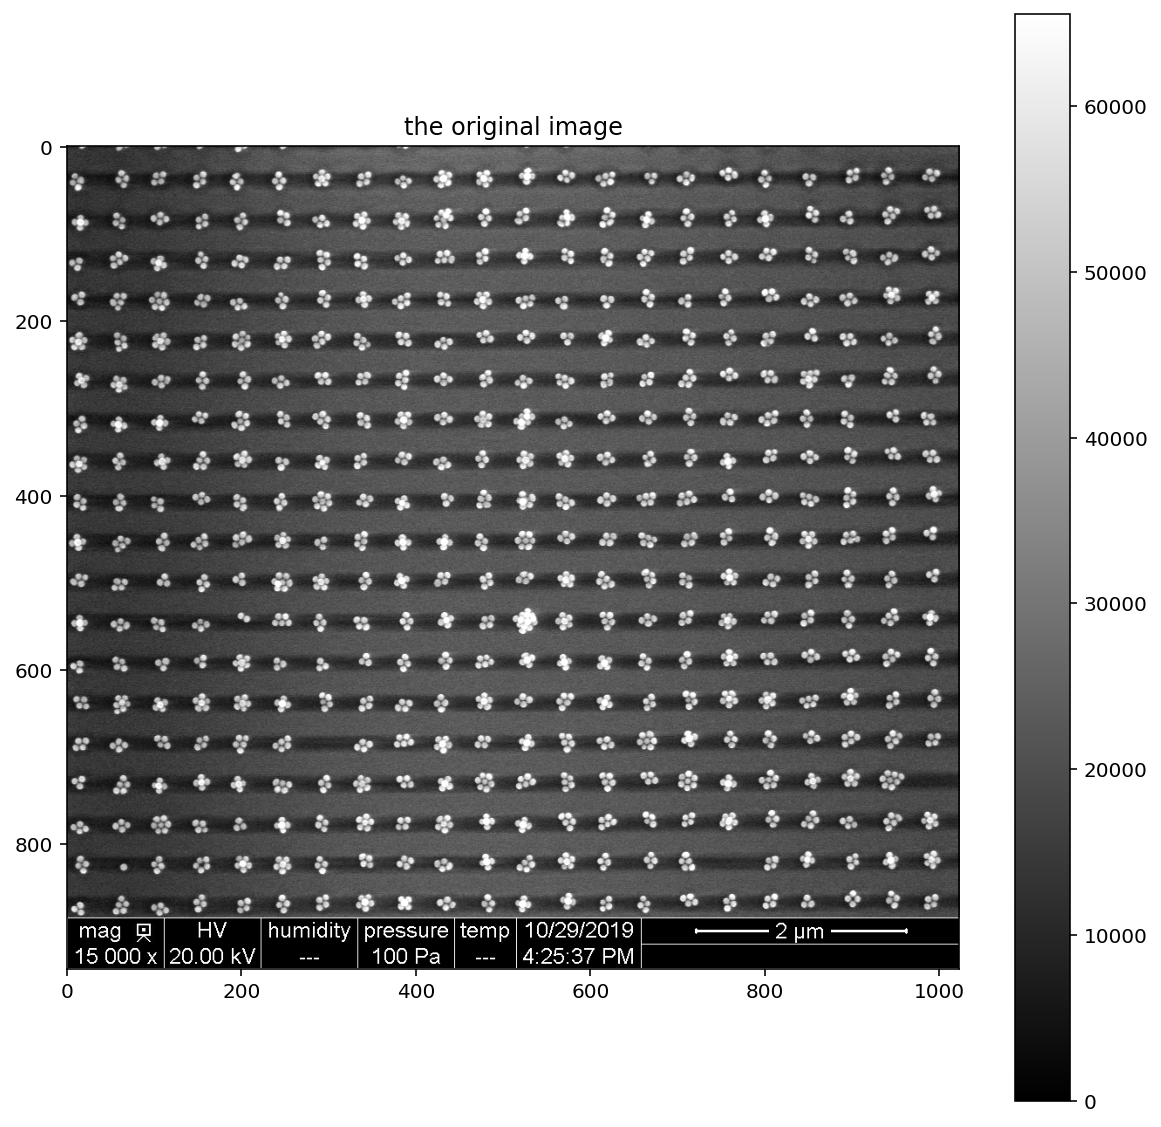

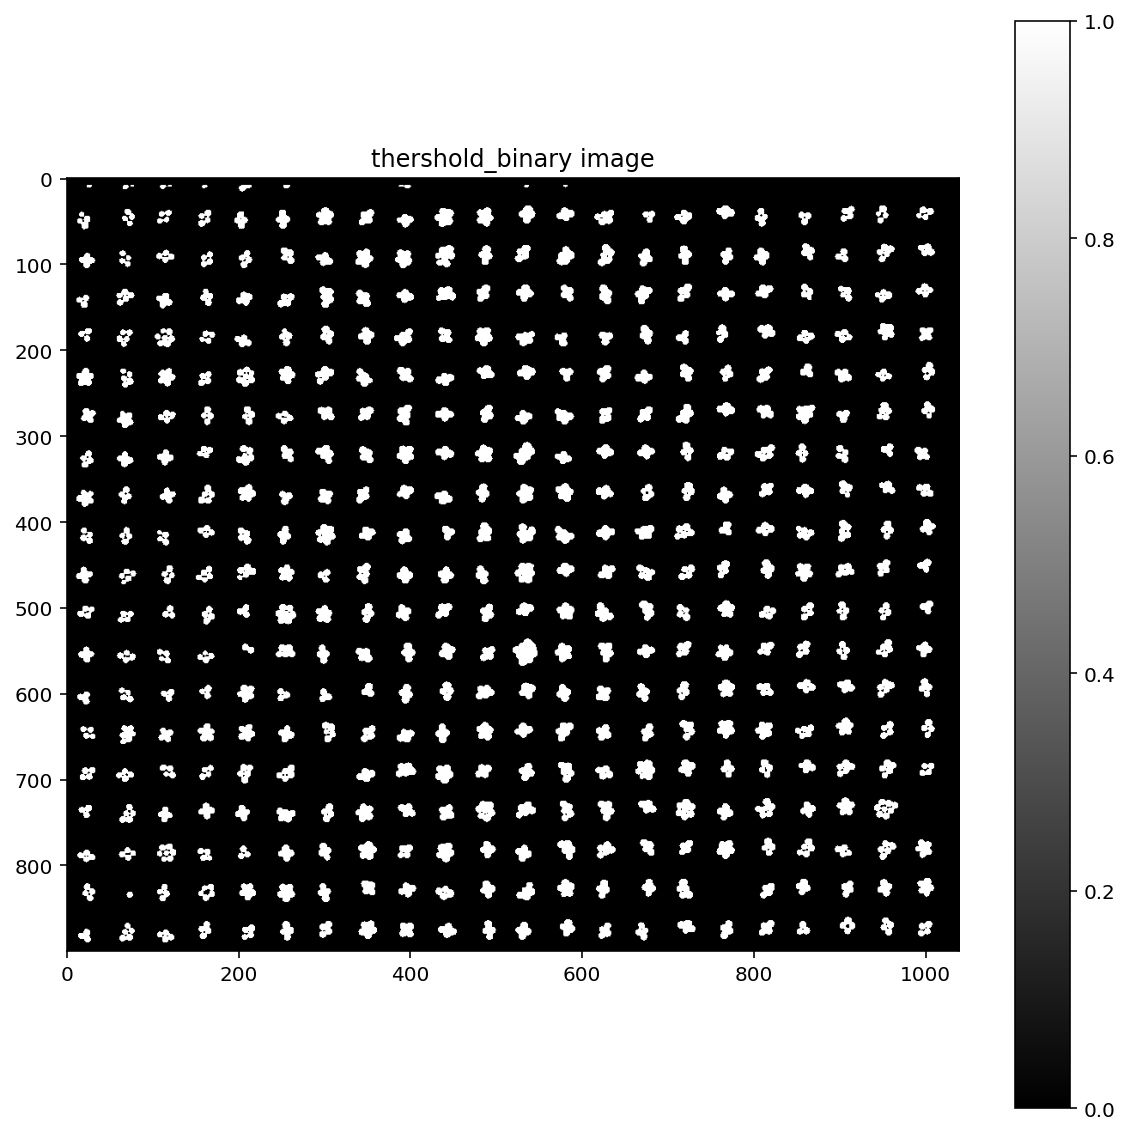

In [2]:
#load the original image from the dataset
pics = ['./images/dataset/001_001.tif',           #0           
        './images/dataset/001_006.tif']            #1
picNUM = 1

# load the image
img = mpimg.imread(pics[picNUM])
# plot the image
ip.plot_image(img, title="the original image")

# crop the footer of the image
img = img[0:884,:] # the same for both images
# plot the image
# ip.plot_image(img, title="the cropped image")

imgROOT = np.pad(img, ((8, 8), (8, 8)), 'minimum').astype(np.float)
# plot the image
# ip.plot_image(img, title="the cropped image")

# reduce noise in the second image
img = ip.filter_image(imgROOT, ip.Gauss5Norm)

# convert the image to binary image
img = ip.threshold2(img, 30000)
imgBIN = ip.threshold_binary(img, np.mean(img))
ip.plot_image(imgBIN, title="thershold_binary image", vmin=0, vmax=1)

In [3]:
t.tic()
# reduce noise and connect near particles each cluster
# imgBIN = ip.img_open(imgBIN, ip.N4)
# morpho_imgBIN = ip.img_dilate(imgBIN, ip.N4)

# reduce noise
morpho_imgBIN=ndi.binary_erosion(imgBIN)
# connect near particles each cluster
morpho_imgBIN=ndi.binary_dilation(morpho_imgBIN,iterations=2)
# convert boolean array to int array for processing
morpho_imgBIN = morpho_imgBIN.astype(int)
t.toc()

Elapsed time: 0.049970 seconds.



0.04996967315673828

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1232fa05880>)

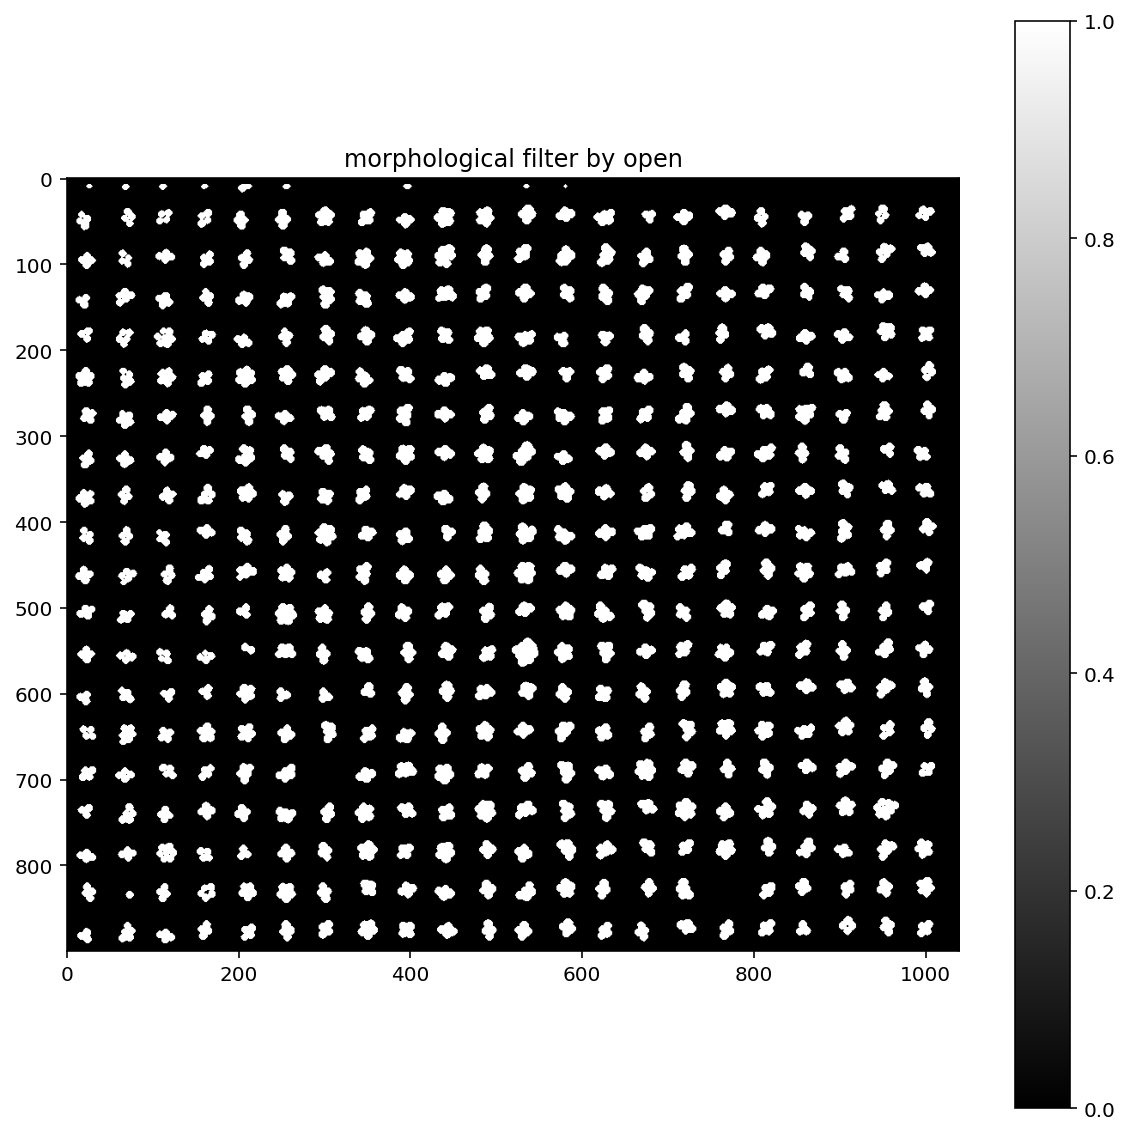

In [4]:
ip.plot_image(morpho_imgBIN,title="morphological filter by open", vmin=0, vmax=1)

(900, 1040)
424
Elapsed time: 94.834280 seconds.



(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1232f8bac40>)

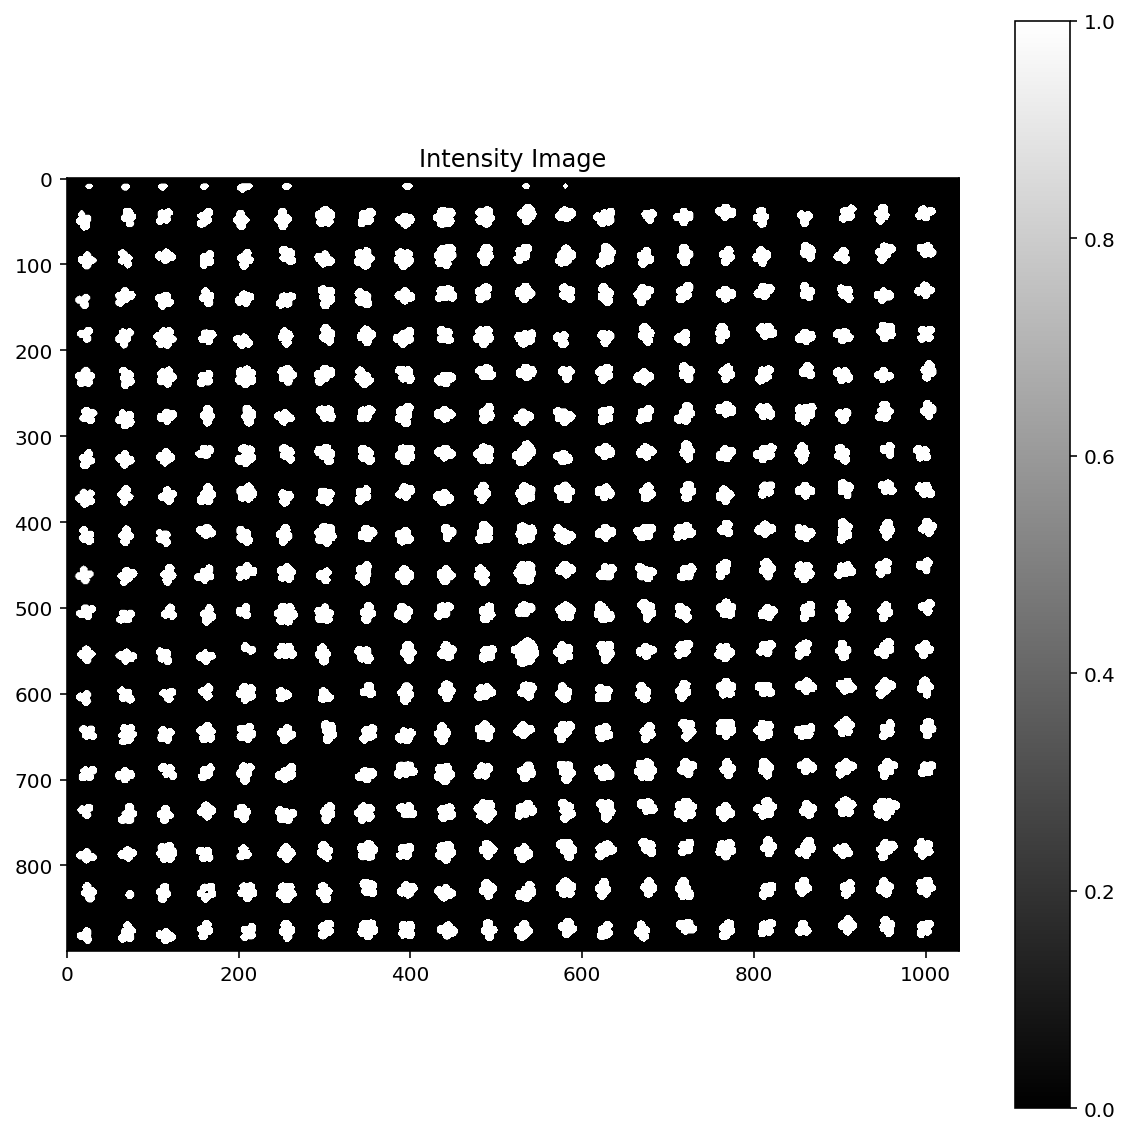

In [5]:
t.tic()
print(morpho_imgBIN.shape)
#SequentialLabeling runs faster than FloodFillLabeling
imgLABEL = ip.SequentialLabeling(morpho_imgBIN)
# imgLABEL = ip.FloodFillLabeling(morpho_imgBIN, method='BF')
t.toc()
ip.plot_image(imgLABEL, cmap = plt.cm.gray, vmax=1)

In [6]:
# positioning the clusters
cluster_position = []
number_of_cluster = np.amax(imgLABEL)
print(number_of_cluster)
for i in range(1,number_of_cluster+1):
    xmin = min(np.where(imgLABEL == i)[1])
    xmax = max(np.where(imgLABEL == i)[1])
    ymin = min(np.where(imgLABEL == i)[0])
    ymax = max(np.where(imgLABEL == i)[0])
    cluster_position.append((ymin, ymax, xmin, xmax))

424


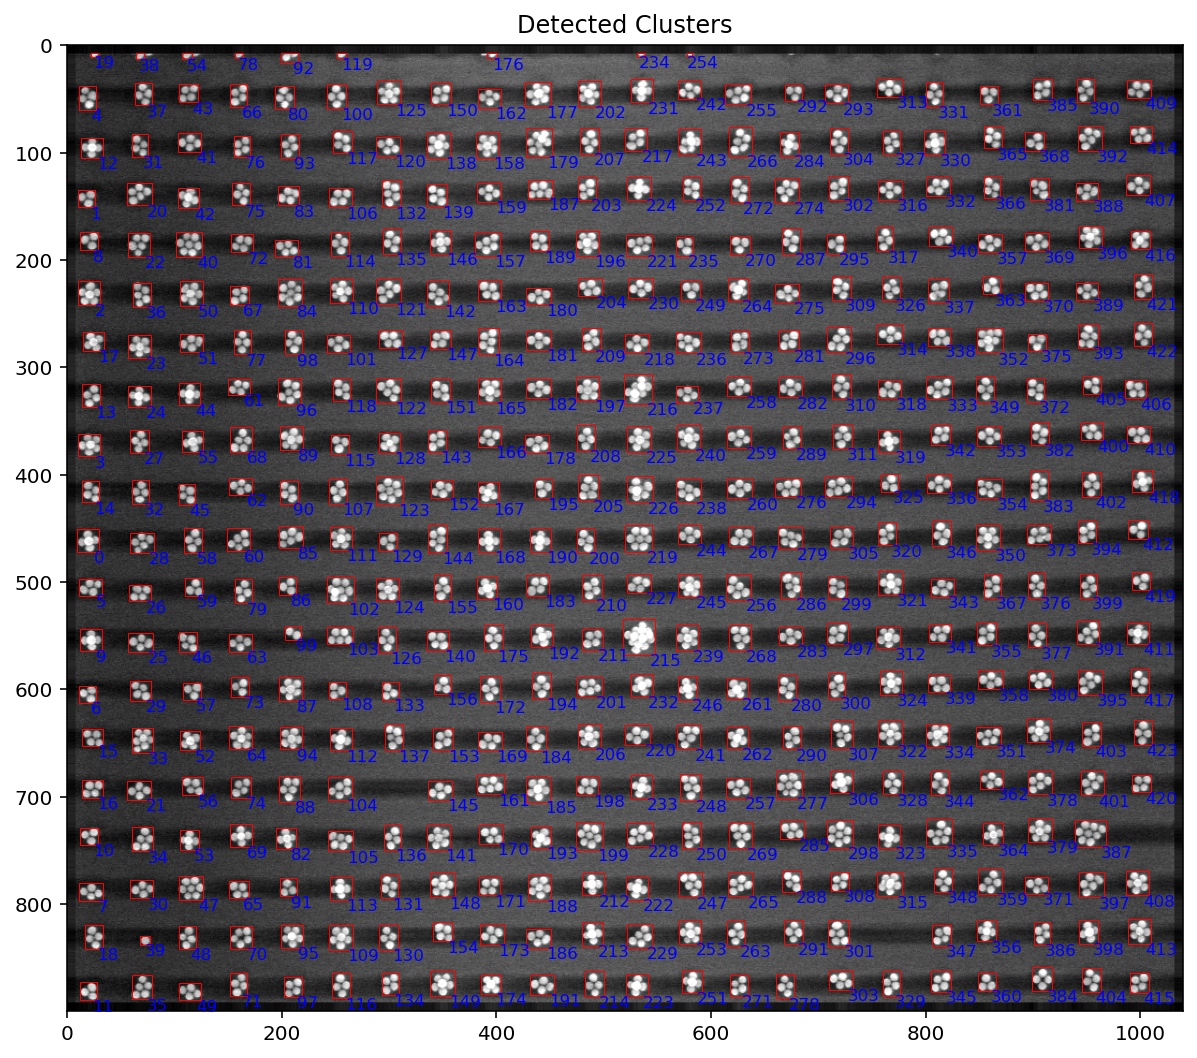

In [7]:
# plot original image with rectangles around all detected clusters
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Detected Clusters")
ax.imshow(imgROOT, cmap='gray', vmax=65536)
for i in range(0, number_of_cluster):
    ymin, ymax, xmin, xmax = cluster_position[i]
    rect = plt.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, linewidth=0.5, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(xmax-5, ymax+10, str(i), fontsize = 'small', color='blue')

In [8]:
def load_process_img(img, plot):
    #convert the image of the cluster to binary image
    imgBIN=ip.threshold_binary(img,1) 
    
    # Distance transform
    IMG_DIST = ip.DistanceTransform(imgBIN)

    # Find the local maxima in the distance map:
    local_maxi = peak_local_max(IMG_DIST, indices=False, footprint=np.ones((3, 3)), min_distance=1, labels=imgBIN)

    # Define these Maxima as "seed points" / labels for the marker-based watershed: 
    markers = ndi.label(local_maxi)[0]

    # Run the watershed (on the inversed distance map:)
    labels = watershed(-IMG_DIST, markers, mask=imgBIN)
   
    # Plot the results: 
    if plot:
        fig, axes = plt.subplots(ncols=4, figsize=(12, 3), sharex=True, sharey=True)
        ax = axes.ravel()
        
        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title('Original objects')
        ax[1].imshow(imgBIN, cmap=plt.cm.gray)
        ax[1].set_title('Binary objects')
        ax[2].imshow(IMG_DIST, cmap=plt.cm.gray)
        ax[2].set_title('Distances')
        ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
        ax[3].set_title('Separated objects')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    
    return labels

In [9]:
from matplotlib.ticker import MaxNLocator

def plot_result(result, xlabel='x', ylabel='y'):
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel, color='tab:blue')
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    counts, bins = np.histogram(result)
    ax[0].hist(bins[:-1], bins, weights=counts)
    
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel, color='tab:blue')
    ax[1].boxplot(result, vert=False)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel(ylabel, color='tab:blue')
    ax[2].violinplot(result, vert=False)
    plt.show() 

In [10]:
def statistic(result):
#     print(result)
    print(np.mean(result)) # sum of all the entries divided by the number of entries / the average value 
    print(np.median(result)) # the middle point of the number of entries
    print(np.var(result)) # measures how far a set of numbers is spread out from their average value
    print(np.std(result)) # a measure of the amount of variation or dispersion of a set of values.

In [11]:
particles_each_cluster = []
for i in range(0,number_of_cluster):
    ymin, ymax, xmin, xmax = cluster_position[i]
    cluster = img[ymin:ymax, xmin:xmax]
    imgLabels = load_process_img(cluster,plot=False)
    cnt = np.amax(imgLabels)
    particles_each_cluster.append(cnt)

In [12]:
np.save('./images/dataset/006_particles', particles_each_cluster)

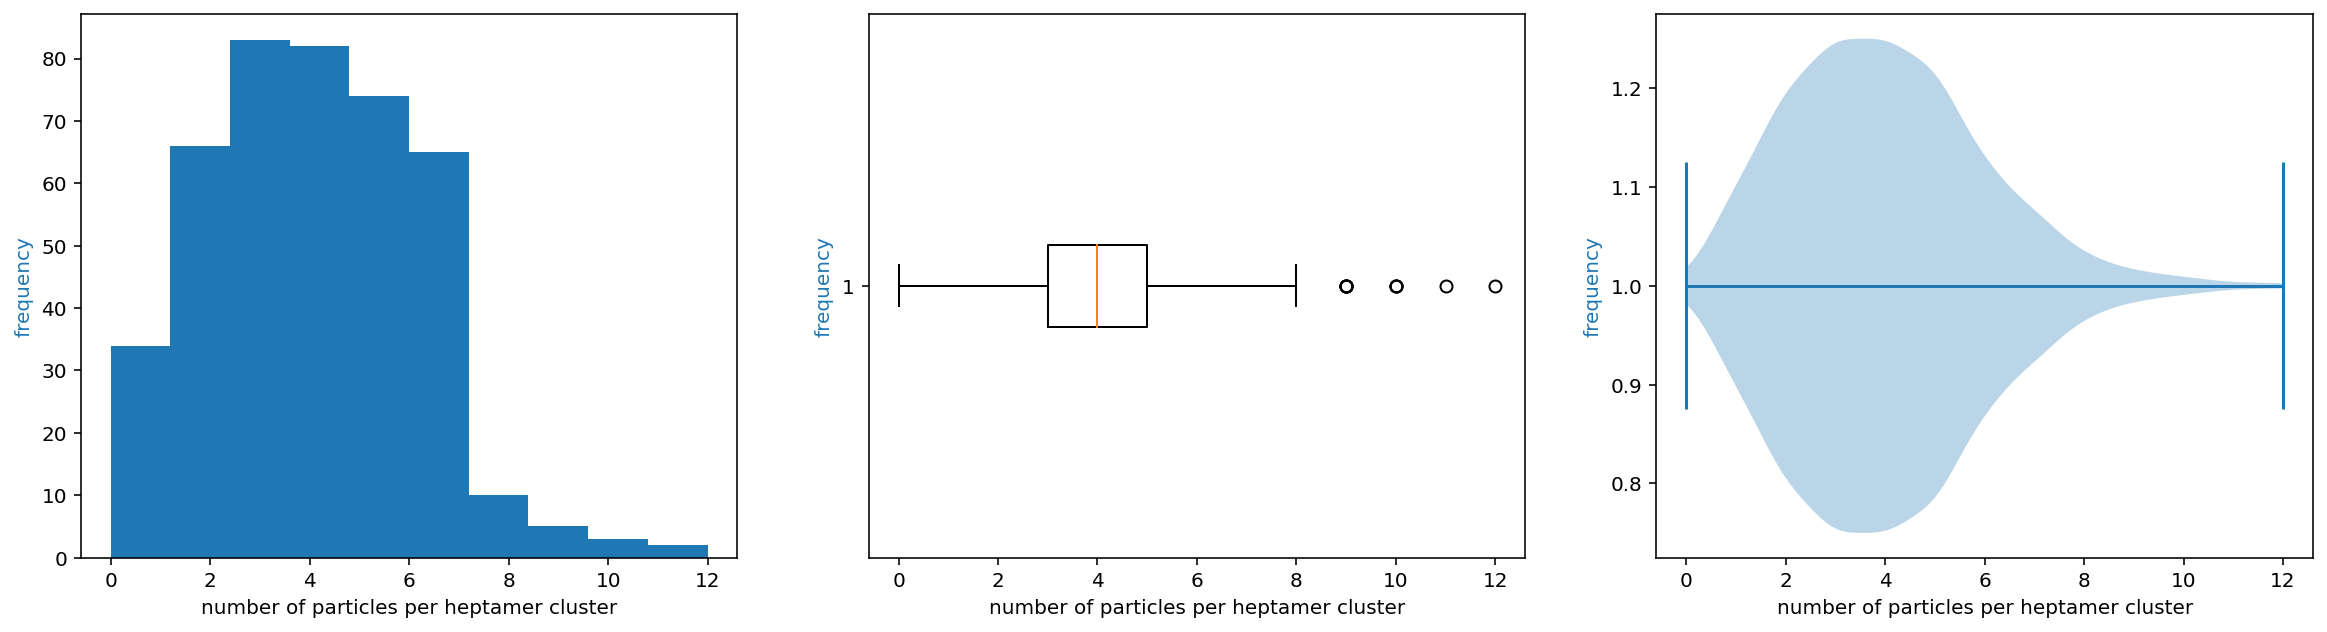

In [13]:
plot_result(particles_each_cluster, xlabel='number of particles per heptamer cluster', ylabel='frequency')

In [14]:
statistic(particles_each_cluster)

4.02122641509434
4.0
3.8320966091135635
1.957574164396732


In [15]:
def measure_diameter(labels):
    diameter = []
    for i in range(1, np.amax(labels)+1):
        xd = np.max(np.sum(labels==i, axis=1)) # get the longest diameter with respect to X axis
        yd = np.max(np.sum(labels==i, axis=0)) # get the longest diameter with respect to Y axis
        d = max(xd,yd)
        diameter.append(d) # compare both axis and get the longer diameter
    return diameter

def get_chain_ratio(img, img_number):
    # crop the image to get the ruler
    if img_number == 0:
        img_ruler=img[890:915, 525:1020] # 001_001.tif
        mag = 30000
    elif img_number == 1:
        img_ruler=img[890:915, 700:1020] #001_006.tif
        mag = 15000
    img_ruler = ip.threshold_binary(img_ruler,np.mean(img_ruler))
    left_point = min(np.where(img_ruler == 1)[1]) # return the left edge of the ruler
    right_point = max(np.where(img_ruler == 1)[1]) # return the right edge of the ruler
    number_pixel_of_ruler = right_point - left_point
    return number_pixel_of_ruler

def pixel_to_meter(measure_in_pixel, ratio):
    measure_in_meter = []
    for i in measure_in_pixel:
        measure_in_meter.append((1000* i * 2 / ratio)) # 2 micro meters
    return measure_in_meter

In [16]:
diameter_each_particle = []
ruler = get_chain_ratio(img,picNUM)
for i in range(0,number_of_cluster):
    ymin, ymax, xmin, xmax = cluster_position[i]
    cluster = img[ymin:ymax, xmin:xmax]
    imgLabels = load_process_img(cluster,plot=False)
    diameter_in_pixel = measure_diameter(imgLabels)
    diameter_in_meter = pixel_to_meter(diameter_in_pixel, ruler)
    diameter_each_particle = diameter_each_particle + diameter_in_meter

In [17]:
np.save('./images/dataset/006_diameter', diameter_each_particle)

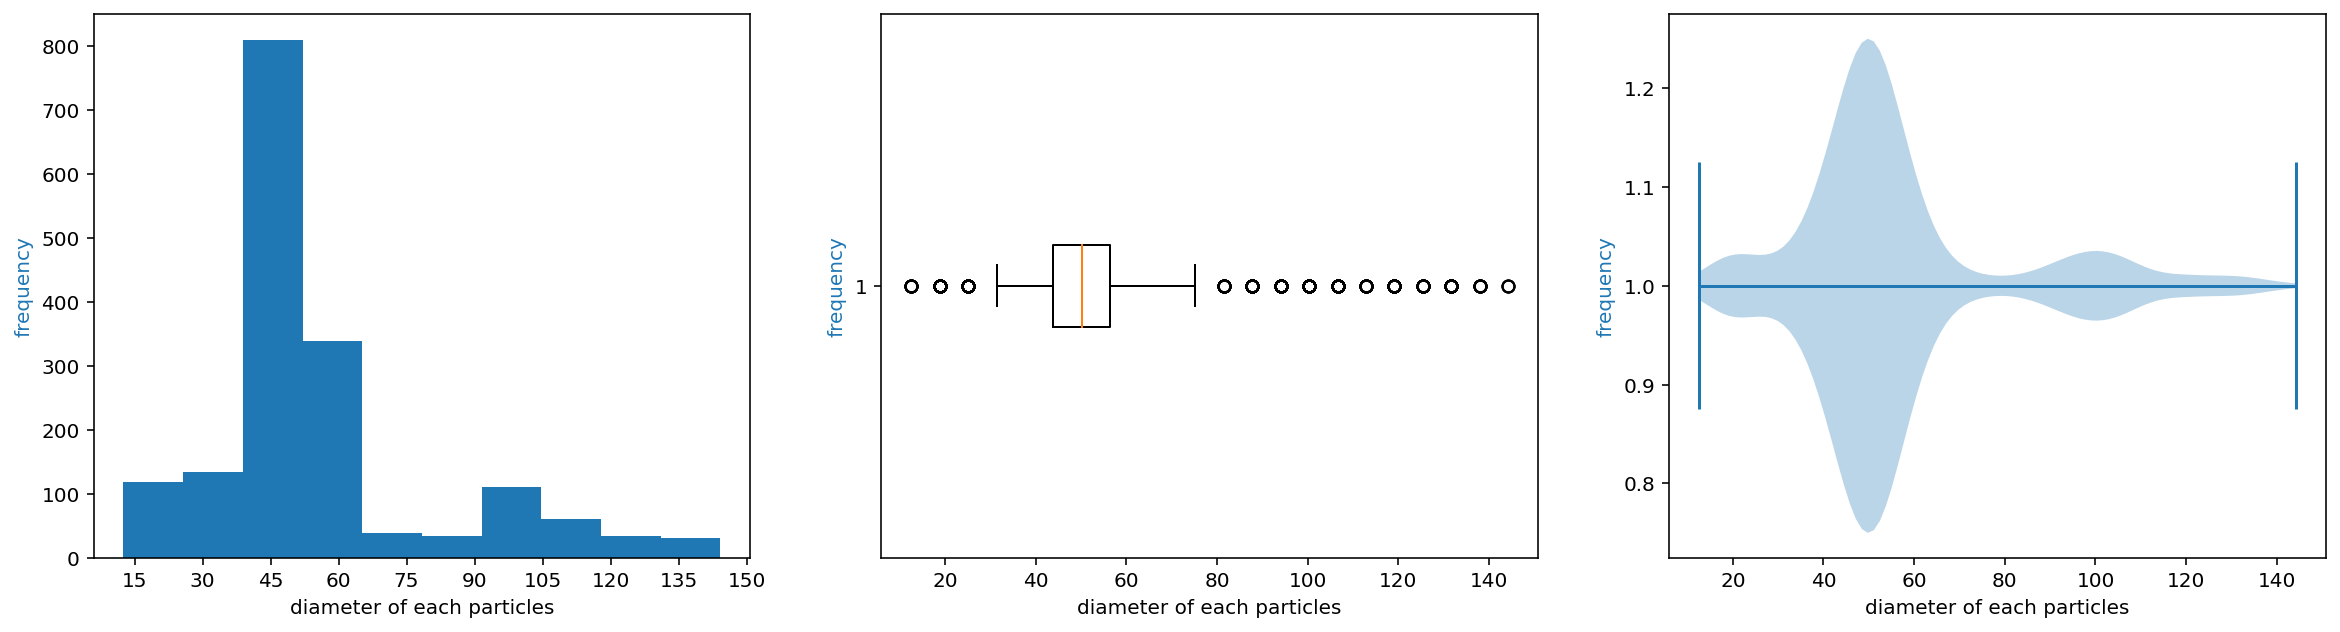

In [18]:
plot_result(diameter_each_particle, xlabel='diameter of each particles', ylabel='frequency')

In [19]:
statistic(diameter_each_particle)

56.624900026659546
50.156739811912225
578.7187853240594
24.05657467978472
